# Introduction
This notebook implements Linear Regression. There are two implementations. The first implementation uses the exact formula. The second implementation uses Gradient Descent. 

- Algorithms: Linear Regression (Exact and Gradient Descent)
- DataSets:   "linear_regression" 
- Video: To Be Added.


# Linear Regression
The hypothesis set for linear regression is 

$$ H = \{ h(x)=w^Tx \mid w\in R^{d+1}\} $$

Given data $D=\{(x_1, y_1), ..., (x_N, y_N)\}$ we want to minimize the following error function  

$$E_{in}(h)=\sum_{i=1}^N (h(x_i)-y_i)^2$$

Notice that any hypothesis $h(x)=w^Tx\in H$ is described exactly by its weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}(w)$. We shall later prove that the following $w^*$ minimizes the above error $E_{in}$

$$w^* = (X^TX)^{-1}X^Ty$$

In the code below we use this as a fact and postpone the proof until the end of this notebook. ....

# Code: Linear Regression
The following class implements the class `LinearRegression`. 

<IPython.core.display.Javascript object>


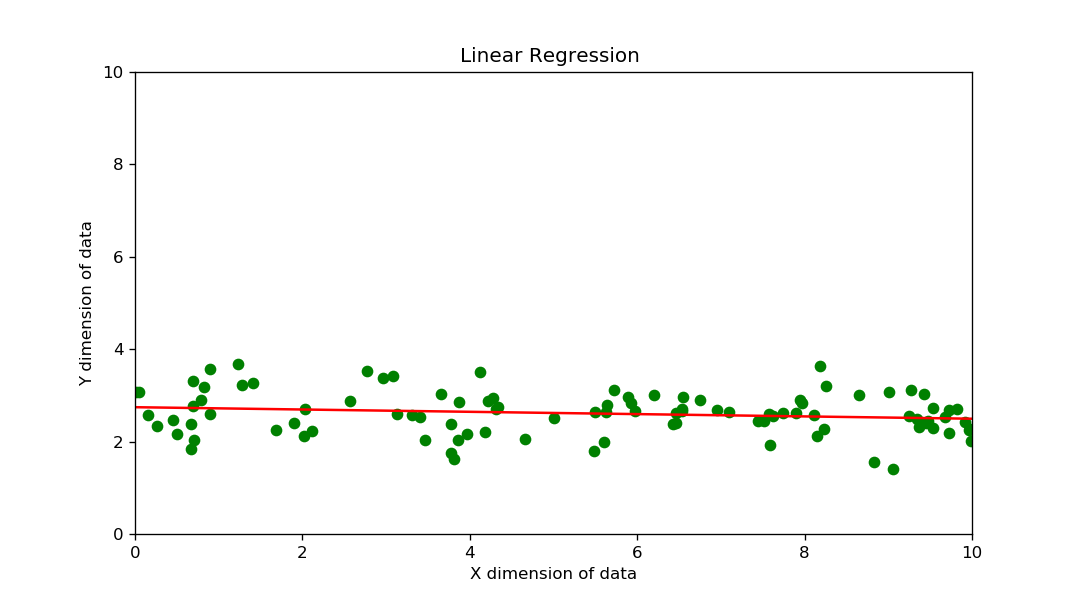

Least Squares Error: 	 0.209166896794
Uknown Target Function:  -0.02*x+2.64
Least Squares Fit: 	 -0.025*x+2.745


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import dataset as ds

class LinearRegression:
    
    def __init__(self, visualize=False):
        self.visualize = visualize
        if self.visualize:
            self.fig, self.ax_data = plt.subplots(1, 1, figsize=(9, 5))
    
    def fit(self, X, y):
        pseudo_inverse = np.linalg.inv( X.T @ X ) @ X.T
        self.w = pseudo_inverse @ y
        
        if self.visualize: self.do_visualize(X, y)
    
    def predict(self, X):
        return X @ self.w
    
    def error(self, X, y):
        """ Least Squares Error """
        n, d = X.shape
        pred = self.predict(X)
        diff = pred - y
        error = 1/n * np.sum(diff**2)
        return error
        
    
    def do_visualize(self, X, y):
        
        n, d = X.shape
        
        self.ax_data.set_title("Linear Regression ")
        self.ax_data.set_xlabel("X dimension of data")
        self.ax_data.set_ylabel("Y dimension of data")
        self.ax_data.set_xlim(0, 10)
        self.ax_data.set_ylim(0, 10)
        self.ax_data.plot(X[:,1], y, 'go')
        
        # visualize line 
        self.ax_data.plot([0, 10], [self.w[0], self.w[1]*10+self.w[0]], '-r')
        
        # plot lines for each point to line
        plt.show()
        
    def __str__(self):
        return str(round(self.w[1], 3)) + "*x+" + str(round(self.w[0], 3))
    
# Generate data and fit LinearRegression to the data. 
data = ds.DataSet("linear_regression")
linreg = LinearRegression(visualize=True)
linreg.fit(data.X, data.y)
print("Least Squares Error: \t", linreg.error(data.X, data.y))
print("Uknown Target Function: ", data.target_function)
print("Least Squares Fit: \t", linreg)

<div style="border: 1px solid black; padding: 16px; "><b>Observation</b>: Typically one thinks of learning/training as an iterative process. This is not the case for exact Linear Regression where the weights $w^*$ are computed in one step! This might be a bit confusing, but from a Machine Learning viewpoint this is still learning. </div> 

# Time Budget for exact Linear Regression 
Remember the formula we used to find our weights

$$w^* = (X^TX)^{-1}X^Ty$$

What is the <a href="https://en.wikipedia.org/wiki/Time_complexity" target="_new">time complexity</a> of evaluating this formula? The matrix $X$ has dimension $n\times d$ and the vector $y$ has dimensions $n\times 1$. For simlicitly let's assume matrix inversion takes $O(n^3)$ time. 


<table>
<tr>
<td><b>Operation</b></td>
<td><b>Cost</b></td>
</tr>

<tr>
<td>Multiply $X^T$ and $X$</td>
<td>$d^2 n$</td>
</tr>

<tr>
<td>Invert $X^TX$</td>
<td>$d^3$</td>
</tr>

<tr>
<td>Multiply $(X^TX)^{-1}$ and $X^T$</td>
<td>$d^2n$</td>
</tr>

<tr>
<td>Multiply $(X^TX)^{-1}X^T$ and $y$</td>
<td>$dn$</td>
</tr>

<tr>
<td>Sum</td>
<td>$d^2n+d^3+d^2n+dn$</td>
</tr>

<tr>
<td><a href="https://en.wikipedia.org/wiki/Big_O_notation" target="_new">Big-O notation</a></td>
<td>$O(d^2n+d^3)$</td>
</tr>
</table>

For large data sets this can sometimes be too slow. Especially if $d$ is very large ($d>n$). The time it takes to invert $X^TX$ will then be $d^3$. In the following section we investigate how to circumvent this by using Gradient Descent.

# Linear Regression (Gradient Descent)
Remember that we are trying to find a $w$ that minimizes the following error function

$$E_{in}(w)=\sum_{i=1}^N (w^Tx_i-y_i)^2$$

Imagine that our error function looks like

<img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/gradient-optimization_files/ball.png" style="width: auto; height: 200px; " />

The x-axis represents different weights $w$ and the y-axis represents the in-sample error of such $w$. By using the formula for $w^*$ we were able to find the $w$ at the bottom of the parabola. 

Instead of using the formula we will use an algorithm called Gradient Descent. You can think of Gradient Descent as dropping a ball at a random point on the parabola. The ball would then slide towards the bottom and give us a good solution! The ball might not end exactly at the bottom, but it will often get close enough. 

But how do we drop a ball on our error function? Remember our error function was 

$$E_{in}(h)=\sum_{i=1}^N (h(x_i)-y_i)^2$$

We shall later prove that the gradient of this error function is

$$\nabla_w E_{in}(w)=\frac{2}{N}\left(X^TXw-X^Ty\right)$$

Gradient Descent then does the following: make an initial guess on $w$, compute the gradient of our error and iteratively update $w$ in the negative direction of the gradient. The following pseudocode gives a more complete picture

    w = initialize random
    for i=1,...,number_iterations:
       gradient = compute_gradient(..)
       w = w - learning_rate * gradient

Here `learning_rate` is the size of the step we take each iteration (it is also referred to as `step_size`). 

# Code: Linear Regression with Gradient Descent

In [12]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import dataset as ds

class LinearRegressionGD(LinearRegression):
    
    def __init__(self, visualize=False):
        self.visualize = visualize
        if self.visualize:
            self.fig, (self.ax_data, self.ax_error) = plt.subplots(1, 2, figsize=(9, 5))
            self.errors = []
    
    
    def fit(self, X, y, rounds, learning_rate):
        N, d = X.shape
        
        # Preprocess X.T @ X and X.T @ y so we don't have to compute them each iteration. 
        X_transpose_X = X.T @ X
        X_transpose_y = X.T @ y
        
        # Initialize weights at random
        self.w = np.random.rand(d)
        
        # Perform 'rounds' steps of gradient descent
        for i in range(rounds): 
            # Compute gradient
            gradient = 2/N * (X_transpose_X @ self.w - X_transpose_y)
         
            # Update weights 
            self.w = self.w - learning_rate * gradient
        
            # Visualize if enabled
            if self.visualize: self.do_visualize(X, y)
        
    
    def do_visualize(self, X, y):
        n, d = X.shape
        
        self.errors.append(self.error(X, y))
        
        self.ax_data.cla()
        self.ax_data.set_title("Linear Regression (Gradient Descent)")
        self.ax_data.set_xlabel("X dimension of data")
        self.ax_data.set_ylabel("Y dimension of data")
        self.ax_data.set_xlim(0, 10)
        self.ax_data.set_ylim(0, 10)
        self.ax_data.plot(X[:,1], y, 'go')
        
        self.ax_error.set_title("Average Sum Squared Error")
        self.ax_error.set_xlabel("X dimension of data")
        self.ax_error.set_ylabel("Y dimension of data")
        self.ax_error.plot(range(1, len(self.errors)+1), self.errors, 'b-')
        
        # visualize line 
        self.ax_data.plot([0, 10], [self.w[0], self.w[1]*10+self.w[0]], '-r')
        
        # plot lines for each point to line
        self.fig.canvas.draw()

data = ds.DataSet("linear_regression")
linreg = LinearRegressionGD(visualize=True)
linreg.fit(data.X, data.y, 1000, 0.02)
print("Least Squares Error: \t", linreg.error(data.X, data.y))
print("Uknown Target Function: ", data.target_function)
print("Least Squares Fit: \t", linreg)

NameError: name 'LinearRegression' is not defined

# The Battle: Exact vs. Gradient Descent
The following code runs an experiment to compare the two versions of gradient descent. It compares two things for $n=10^4$ and $d=10^3, ..., 10^5$. 

1. How much time does different algorithms take? 
2. How much is Linear Regression with Gradient Descent "away" from the exact solution?

<IPython.core.display.Javascript object>


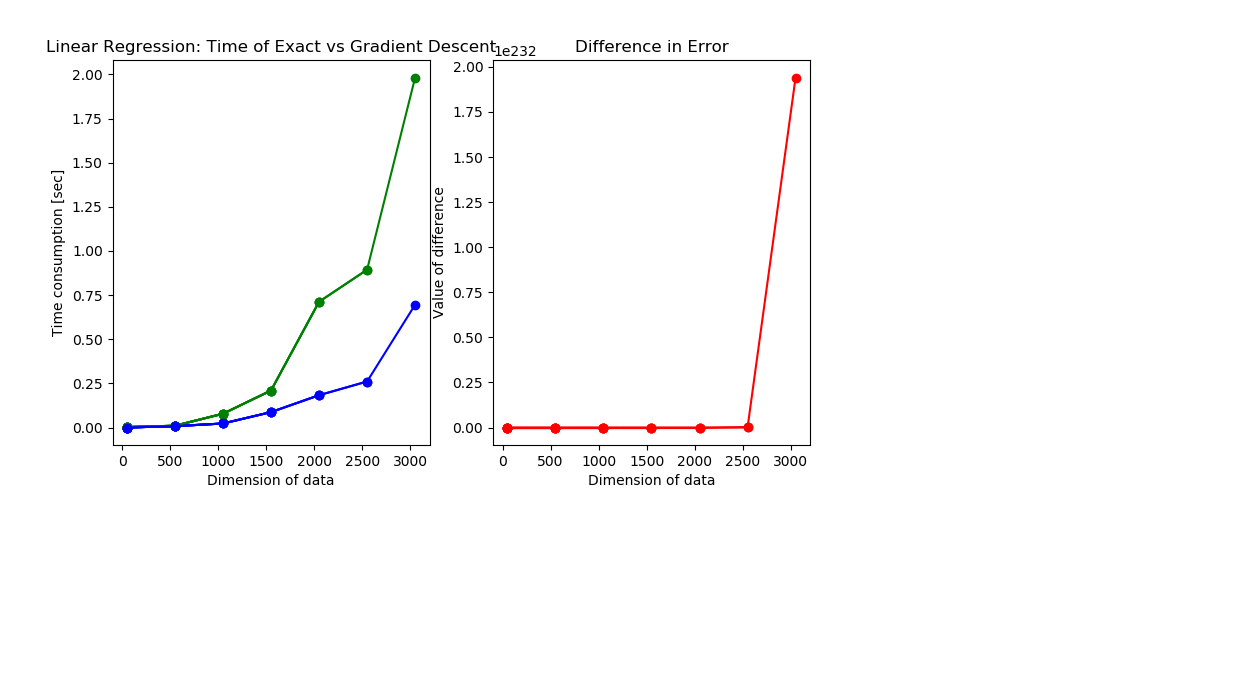

KeyboardInterrupt: 

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time

def experiment():
    time_linreg    = []
    time_linreg_gd = []
    error_linreg    = []
    error_linreg_gd = []
    xs = []

    fig, (ax_time, ax_error) = plt.subplots(1, 2, figsize=(9, 5))

    n = 100
    
    for d in range(50, 6000, 500):
        xs.append(d)

        # Generate a data set with 'n' points
        data = ds.DataSet("linear_regression", n=n, d=d)

        # Train Lienar Regression exact
        linreg = LinearRegression()
        t0 = time.time()
        linreg.fit(data.X, data.y)
        t1 = time.time()

        time_linreg.append(t1-t0)
        error_linreg.append(linreg.error(data.X, data.y))

        # Train linear regression with gradient descent
        linreg_gd = LinearRegressionGD()
        t2 = time.time()
        linreg_gd.fit(data.X, data.y, rounds=100, learning_rate=0.01)
        t3 = time.time()

        time_linreg_gd.append(t3-t2)
        error_linreg_gd.append(linreg_gd.error(data.X, data.y))

        # plot the time consumption of the two algorithms
        ax_time.plot(xs, time_linreg, '-go')
        ax_time.plot(xs, time_linreg_gd, '-bo')
    
        # Plot the difference in sum squared error of exact linear regression
        # and the gradient descent implementation
        ax_error.plot(xs, np.abs(np.array(error_linreg_gd) - np.array(error_linreg)), '-ro')
        
        # Add title and x&y axis labels. 
        ax_time.set_title("Linear Regression: Time of Exact vs Gradient Descent")
        ax_time.set_xlabel("Dimension of data")
        ax_time.set_ylabel("Time consumption [sec]")

        ax_error.set_title("Difference in Error")
        ax_error.set_xlabel("Dimension of data")
        ax_error.set_ylabel("Value of difference")
        fig.canvas.draw()

    
experiment()

<div style="border: 1px solid black; margin: 16px; padding: 16px"><b>Observation: </b>The situation above is constructed to show the advantages of Gradient Descent for Linear Regression. It is a bit artificial. The number of data points is $n=100$ and the dimensions range from $d=50,...,5000$. In practice data usually <b>don't</b> looks like this. Also, the error of the Gradient Descent algorithm sky-rockets!</div>

# Math: Deriving the Equations
Remember we considered the following error function

$$E_{in}(h)=\sum_{i=1}^n (h(x_i)-y_i)^2 \quad\quad \text{where}\quad\quad h(x)=w^Tx$$

Inserting $h(x)=w^Tx$ we could write the error function as

$$E_{in}(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2$$

Let us denote order the data in matrices and vectors as follows

$$
X=\begin{pmatrix}
    - & x_1^T & -\\
      & \vdots &  \\
    - & x_N^T & -
\end{pmatrix}\in R^{N\times d+1}\quad y=\begin{pmatrix}y_1\\\vdots\\y_N\end{pmatrix}\in R^N \quad w=\begin{pmatrix}w_0 \\ w_1 \\\vdots\\w_d\end{pmatrix} \in R^{d+1}$$

Notice that the matrix product $Xw-y$ has a close relation to our error function

$$Xw-y=\begin{pmatrix} x_1^T w\\ \vdots \\x_N w\end{pmatrix}-\begin{pmatrix}y_1\\\vdots \\y_N\end{pmatrix}$$

Each part of the sum in $E_{in}$ corresponds an entry in the above subtraction! It follows that 

$$E_{in}(w)=\frac{1}{N}||Xw-y||^2$$

Before differentiating we note that we can rewrite the above as

\begin{align}
E_{in}(w)&=\frac{1}{N}\left( (Xw-y)^T (Xw-y)\right)\\
&= \frac{1}{N} \left( (Xw)^T(Xw) - (Xw)^Ty -y^T(Xw) +y^Ty\right) \\
&= \frac{1}{N} \left( w^TX^TXw - 2w^TX^Ty + y^Y \right)
\end{align}

It now becomes a bit easier to differentiate the in-sample error

\begin{align}
\nabla E_{in}(w) &= \frac{1}{N} \left(2 X^TXw - 2X^T y + 0\right)\\
&=\frac{2}{N}\left(X^TXw - X^Ty\right)
\end{align}

Recognise this formula? This is exactly what we used to perform Gradient Descent! To find the exact solution we need to solve the equation

\begin{align}
\nabla E_{in}(w) = 0 
\end{align}

Take a minute to think about this. When is the gradient of a function zero? You should be able to convince yourself this happens exactly at the functions optimum. If we solve the above equation, we will thus get a value $w$ such that $E_{in}$ is an optimum. Our error function is convex and thus has only one optimum, the global minimum, which is the solution to the above equation

Solving the equation is rather straight forward

$$\nabla E_{in}(w) = 0 \quad \Rightarrow \quad X^TXw = X^Ty \quad\Rightarrow\quad w = (X^TX)^{-1}X^Ty$$

Assuming $X^TX$ is invertible.



# (todo) Use Linear Regression for Classification

..


In [41]:
%matplotlib notebook
%run "DataSet.ipynb"

n = 100
data = DataSet("linear_regression", n=n)

data.y = data.y.reshape(n, 1)
data.X = np.concatenate((data.X, data.y), axis=1)
data.y = [data.y >= np.mean(data.y)]
data.y = list(np.array(data.y)*2-1)
print(type(data.y[0]))
print(set(data.y))

data.plot()

linreg = LinearRegression()
linreg.fit(data.X, data.y)
linreg.predict(data.X)


<class 'numpy.ndarray'>


TypeError: unhashable type: 'numpy.ndarray'

# (todo) Experiment: Breast Cancer
explain breast cancer dataset. For allowing visualization, solve it basically by projecting it to low dimension with PCA, then make linear model do rest. Comment that this is a bit cheating as an observation in the end 

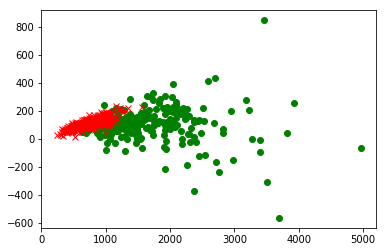

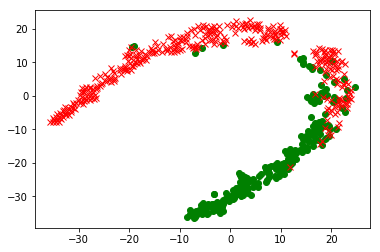

In [3]:
import dataset as ds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = ds.DataSet("breast_cancer")

X = data.X
y = data.y

pca = PCA()
pca.fit(data.X)
pca.components_[:2]

data2d = data.X @ pca.components_[:2].T
data2d.shape

plt.plot(data2d[y == 0][:,0], data2d[y==0][:, 1], 'go')
plt.plot(data2d[y == 1][:,0], data2d[y==1][:, 1], 'rx')
plt.show()

#import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

plt.plot(X_embedded[y == 0][:,0], X_embedded[y==0][:, 1], 'go')
plt.plot(X_embedded[y == 1][:,0], X_embedded[y==1][:, 1], 'rx')
plt.show()

# (todo) Make visualization of 3d Linear Regression

# Errors, Suggestions and Hall Of Fame
If you find any mistakes or have suggestions for improvements reach me at alexmath@cs.au.dk. Any help is very much appreciated, I'll even add your name below for super-awesome everlasting fame!

- ...

# Discussion

<iframe src="..discussionboard/perceptron.html" style="width: 800px; height: 800px; "/></iframe>